In [1]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from pybatteryid.simulation import simulate_model
from pybatteryid.utilities import invert_voltage_function, analyze_dataset, load_model_from_file
from pybatteryid.plotter import plot_time_vs_current, plot_time_vs_voltage, plot_time_vs_temperature

from data import helper

### Example 3.2. Temperature-dependent Model *Validation* for an NMC Battery

This file contains an example to identify battery models for a 2.85 Ah NMC battery. See [1] for more details.

#### References

[1] Sheikh, A. M. A., M. C. F. Donkers, and Henk Jan Bergveld. "Towards temperature-dependent linear parameter-varying models for lithium-ion batteries using novel experimental design." Journal of Energy Storage 119 (2025): 116311. https://doi.org/10.1016/j.est.2025.116311

#### A. Load model

In [2]:
model_file_name = "model_n,l=3,3"
model = load_model_from_file(f'results/nmc_with_temperature/{model_file_name}.npy')

#### B. Load validation dataset

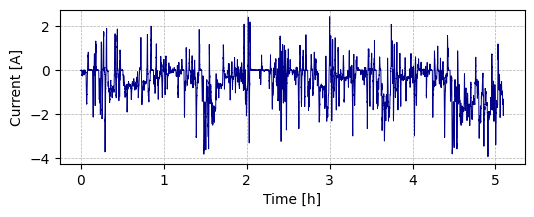

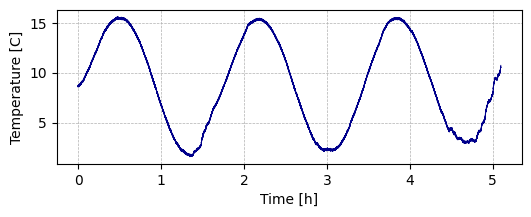

In [3]:
# Possible options: "cold", "normal" and "hot"
kind = 'cold'
dataset = helper.load_npy_datasets(f'data/nmc_with_temperature/validation_data_{kind}.npy')
#
plot_time_vs_current([(dataset['time_values'] / 3600, dataset['current_values'])],
                     units=('h', 'A'), colors=['darkblue'])
plot_time_vs_temperature([(dataset['time_values'] / 3600, dataset['temperature_values'])],
                     units=('h', 'C'), colors=['darkblue'])

We determine the initial SOC for the above dataset by inverting the EMF function.

In [4]:
initial_soc = invert_voltage_function(model.emf_function,
                                      dataset['voltage_values'][0],
                                      dataset['temperature_values'][0])
dataset['initial_soc'] = initial_soc

We can also analyze the dataset.

In [5]:
analyze_dataset(dataset, model.battery_capacity, model.sampling_period, model.emf_function)

                 Dataset analysis                  
┌────────────────────────────┬────────────────────┐
│ Number of samples          │ 18351              │
│ Experiment time [s], [h]   │ 18350.000, 5.097   │
│ Extracted charge [C], [Ah] │ 9308.223, 2.58562  │
│ Initial voltage [V]        │ 4.19417            │
│ Voltage range [V]          │ (2.51769, 4.24255) │
│ SOC range [%]              │ (9.91, 99.89)      │
│ Temperature range [°C]     │ (1.59, 15.60)      │
└────────────────────────────┴────────────────────┘

We prepare the input profile that will be simulated using the identified model.

In [6]:
# To perform fair comparison, we provide same number of initial
# voltage values to each model. For example, the model with n=4
# requires four initial voltage values. If n=4 is the largest model
# order to be investigated, then we provide four initial values to all
# models, that is, n=1,2,3,4. Note that such consideration may not have
# significant impact on the actual comparison, but is legit in principle.
no_of_initial_values = 4
# 
current_profile = {'initial_soc': initial_soc,
                   'time_values': dataset['time_values'],
                   'current_values': dataset['current_values'],
                   'temperature_values': dataset['temperature_values'],
                   'voltage_values': dataset['voltage_values'][:no_of_initial_values]}

#### C. Simulate output voltage

In [7]:
voltage_simulated = simulate_model(model, current_profile)

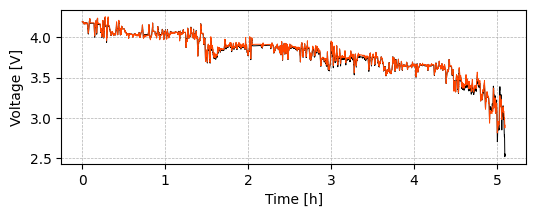

In [8]:
#
plot_time_vs_voltage([(dataset['time_values'] / 3600, dataset['voltage_values']), (dataset['time_values'] / 3600, voltage_simulated)],
                     units=('h', 'V'), colors=['k', 'orangered'])

#### G. Error analysis

In [9]:
# We find error values for the whole region
rmse = root_mean_squared_error( voltage_simulated[no_of_initial_values:], dataset['voltage_values'][no_of_initial_values:] )
mae = mean_absolute_error( voltage_simulated[no_of_initial_values:], dataset['voltage_values'][no_of_initial_values:] )

print(f"The errors are given as: (RMSE, MAE) = ({rmse * 1e3:.2f} mV, {mae * 1e3:.2f} mV)")

The errors are given as: (RMSE, MAE) = (20.23 mV, 10.64 mV)
